# CE: "Kanselering "Da da da daaaa" i Beethovens 5. bomb av en sang.".
### Av B-dog og Siggen.

In [1]:
# Nødvendige importer
from matplotlib import style
style.use("default") # Gir finere plot for .ipynb filer i VS Code
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore") # Ignorerer advarsler fra numba

### Wavelet analyse av lydsignalet:
Planen er å kjøre en wavelet analyse på lydfilen av sangen og manuelt identifisere hvilke frekvenser som dukker opp når, for så å kunne lage mot frekvensen til hver bølge i lydsignalet. 

### Lydbølge:
Vi begynner med å lage oss en test bølge med to forskjellig frekvenser i forskjellige tidspunkt. Det vi bruker her er 1 Hz frem til 5 sekunder og 0.5 Hz til 10 sekunder. Vi bruker en klassisk cosinus bølge:
$$y(x)=A\cos(\omega x + \phi)$$
Vi ser her også at vi må faseforskyve den andre delen av bølgen slik at den henger pent sammen. Koden for dette ser slik ut:

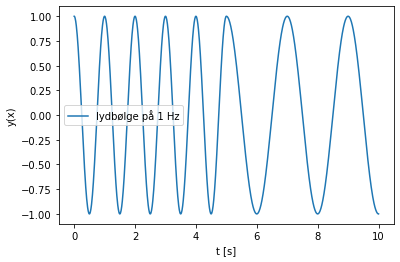

In [2]:
#Definerer variabeler:
omega = 2*np.pi #Vinkelfrekvens
A = 1 #Amplitude
phi = 0 #Forskyvningsledd
x = np.linspace(0,10,1000) #tidsarray
#Første bølge:
y = A*np.cos(omega*x + phi)
#Andre bølge:
for i in range(500):
    y[i+500] = A*np.cos(0.5*omega*x[i+500] + np.pi) #Annen frekvens etter indeks 500
#plot:
plt.Figure(figsize=(16,16)) #justerer plottstørrelsen
plt.plot(x,y,label="lydbølge på 1 Hz") #plotter bølgen
plt.xlabel("t [s]") #x-akse tittel
plt.ylabel("y(x)") #y-akse tittel
plt.legend() #viser navn på graf

Her ser vi da altså en lydbølge på 1 Hz frem til 5 sekunder og 0.5 Hz til 10 sekunder.

### Fourieranalyse:
For å identifisere disse frekvensene fra lydbølgen starter vi med Fourieranalyse. Det er et matematisk verktøy som lar oss gå fra tid på x-aksen til frekvensaksen. Matematisk ser det slik ut:
$$F(\omega) = \frac{1}{2\pi}\int_{-\infty}^{\infty}f(t)e^{i\omega x}dt$$
Vi bruker numpys Forier transformasjon siden vi vil gjøre dette numerisk. Det numpy gjør er kort forklart at den sjekker hvordan høyden går over tid på en bølge med en kjent samplingsfrekvens som vi har lært at skal være: 
$$f_s<2f$$
Hvor fs er samplingsfrekvensen og f er frekvensen til signalet. Dette kalles Nyquist frekvensen og den må oppfylles for at fourieranalysen skal gi rett frekvenser og ikke missforstå signalet til å ha andre frekvenser enn det egentlig har.

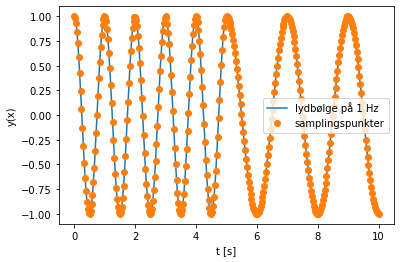

In [3]:
plt.Figure(figsize=(16,16))#justerer figurstørrelsen
plt.plot(x,y,label="lydbølge på 1 Hz") #plotter bølgen
fs = 3 #hvor ofte prikkene i plottet skal komme
plt.plot(x[::fs],y[::fs],"o",label="samplingspunkter") #plotter prikker på grafen som skal være samplingen til numpy
plt.xlabel("t [s]") #x-akse tittel
plt.ylabel("y(x)") #y-akse tittel
plt.legend() #viser graf navn

Vi ser her hvordan prikkene på grafen indikerer hvordan numpys Fourier sampling skjer.

Når vi bruker numpy lager vi en funksjon som vi kan bruke på et hvert signal. Vi plotter både signalet og Fourieranalysen av signalet med denne koden:

In [4]:
@jit
def Fourier(data,fs):
    ## Funksjon som tar inn et data signal (lydfil) og en samplingsfrekvens og gjør en forier analyse av signalet og plotter signalet i tids og frekvens-rommet
    x_n  = data # Dataserien egentlig bytter bare navn
    N = int(len(x_n)) # Antall punkter i signalet
    
    T = N / fs # tital tid for en tidsarray til forertransformasjonen
    dt = 1 / fs # lengden på hvert tidssteg
    t = dt*np.linspace(0, N-1, N) #lager tidssarray
 
    
    X_k = (1/N)*np.fft.fft(x_n) #kjører forier transformasjoenen på signalet
    freq = np.fft.fftfreq(N, dt) #genrerer frekvens domenet til transformasjonen
    #plotter signalet:
    plt.subplot(2,1,1) #generer første subplot
    plt.plot(t, x_n,label="Signal i tidssrommet") #Plotter signalet i tidsrommet
    plt.xlabel('t [s]') #x-akse tittel 
    plt.ylabel('x$_n$') #y-akse tittel
    plt.legend() #Viser graf navn
    #plotter Analysen
    plt.subplot(2,1,2) #generer andre subplot
    plt.plot(freq, np.abs(X_k),label="signalet i frekvensrommet") #Plotter signalet i frekvensrommet
    plt.xlabel('frekvens [Hz]') #x-akse tittel
    plt.ylabel('X$_k$') #y-akse tittel
    plt.legend() #viser grafnavn
    plt.xlim([0, 5]) #begrenser hva som vises på x aksen
    plt.show() #viser plot

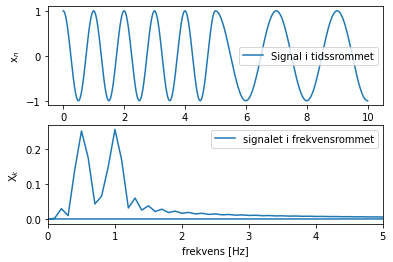

In [5]:
fs = 100 #setter samplingsfrekvensen
Fourier(y,fs) #bruker funksjonen på det genererte signalet

Her ser vi signalet og analysen. Vi ser at vi klarer å idenifisere to frekvenser med de to toppene i plott nr to, men de er ikke så skarpe som vi helst skulle hadt de. Dette kan skylles at en Fourier analyse funker på et signal som består av hele signaler og ikke frekvenser som endrer seg over tid. Dette er grunnen til at vi går over til Waveletanalyse.

### Waveletanalyse:
Denne formen av lydsampling er noe lik Fourier analyse 
$$\gamma (\omega _a,t)$$

In [6]:
@jit
def psi(t,wa,tk,K,fs): # Likning 14.8 i Vistnes
    ## Funksjon som generer Waveleten som skal multipliseres med signalet
    # Disse tre er bare deler av en større funksjon som legges til tilslutt:
    w = np.exp(-1j*wa*(t-tk)) 
    k = np.exp(-K**2)
    gaus = np.exp(-(wa**2 * (t-tk)**2)/(2*K)**2)
    C=0.798*wa/(fs*K) # Ligning 14.7 i Vistnes
    return C*(w-k)*gaus #returnerer waveleten

In [7]:
@jit
def gamma(xn,t,w,K,N,fs): # Likning 14.9 i Vistnes
    ## Funksjon som kjører en versjon av alle frekvenser til alle tidspunkter og summerer produktet av signalet og waveleten og lager en matrise til verdiene
    T = int(len(t)) #Henter lengden på tidsarrayet
    gamma = np.zeros((N,T),dtype=np.complex_) #genererer en tom matrise
    for i in range(N): #løper gjennom alle frekvenser
        for ii in range(T): #løper gjennom alle tidspunkter
            psi1 = psi(t,w[i],t[ii],K,fs) #genererer den gjeldene waveleten
            gamma[i,ii] = np.sum(xn*np.conjugate(psi1)) #summerer opp produktet av signalet og waveleten
    return gamma #returnerer matrisen

In [8]:
@jit
def wavelet(data,K,fs,w,N,t):
    ## Kjører gamma funksjonen og genererer et contour plot med absolutverdien av matrisen siden den blir kompleks
    grid = gamma(data,t,w,K,N,fs) #genererer matrisen
    plt.contourf(t,w,np.abs(grid)) # plotter griddet med frekvensene og tidspunktene
    plt.colorbar() #viser hvilke verdier fargene har
    plt.xlabel("tid [s]") #x-akse tittel
    plt.ylabel("frekvens [log10(2*pi*HZ)]") #y-aksetittel
    plt.show() #viser plottet

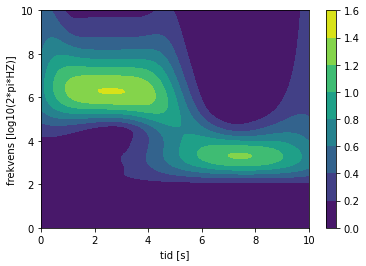

In [9]:
K = 4 #setter K verdien
N = 1000 # definerer hvor mange 
w = np.linspace(0,10,N) #Frekvensarray
t = np.linspace(0,10,1000) #tidsarray
fs = 100 #samplingsfrekvens
wavelet(y,K,fs,w,N,t) # kjører plottefunksjonen

# FFT av DDD

In [10]:
def readWav(filename):
    ## Leser lydfilen med navnet filename, og returnerer tidpunkter t, signal x_n og samplingsfrekvens fs
    fs, data = wavfile.read(filename) # Henter samplingsfrekvens og signaldata fra lydfilen
    x_n = data[:,0] # Henter ut relevant del av signalet
    N = len(x_n) # lengden på lyd signalet
    T = N/fs #lengden på tidsarrayen
    t = np.linspace(0, T, N) # Lager en array med tidpunkter
    return t, x_n, fs # returnerer tidsarrayet, lydsignalet og samplingsfrekvensen

In [11]:
def fourier(t, x_n, N):
    ## Gjør en Fourier-analyse på signal x_n med tidpunkter t. N er lengden vi ønsker til arrayet X_k fra fft.
    ## Returnerer frekvenser freq og utslag X_k fra fft.
    X_k = 1/N * np.fft.fft(x_n, n=N) # Gjør en fft på x_n. Deler på N for å korrigere størrelsen på utslagene.
    dt = t[1] - t[0] #lengden på hvert tidssteg
    freq = np.fft.fftfreq(N, dt) # Finner frekvensområdet til spekteret fra analysen.
    return freq, X_k #returnerer frekvensdomenet og fourier transformasjonen

In [12]:
lydfil_lu = "liteUtdrag.wav" # Lydfilen med et 30s utdrag av symfonien
t_lu, x_n_lu, fs_lu = readWav(lydfil_lu) # Henter data fra lydfilen
N_lu = len(x_n_lu) # Finner lengden til signalet (antall datapunkter)
freq_lu, X_k_lu = fourier(t_lu, x_n_lu, N_lu) # Gjør en Fourieranalyse på utdraget

In [13]:
lydfil_ddd = "DDD.wav" # Lydfilen med kun "DUN DUN DUN DUUUN"-delen av symfonien.
t_ddd, x_n_ddd, fs_ddd = readWav(lydfil_ddd) # Henter data fra lydfilen.
freq_ddd, X_k_ddd = fourier(t_ddd, x_n_ddd, N_lu) # Gjør en Fourieranalyse på DDD. Bruker N_lu for å få lik lengde på X_k_ddd og X_k_lu

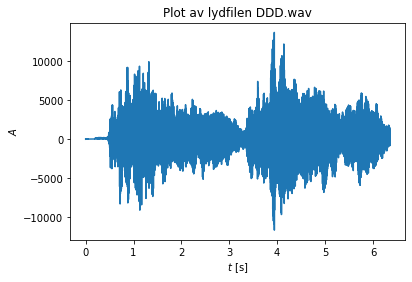

In [14]:
## Plotter lydsignalet fra DDD
plt.title(f"Plot av lydfilen {lydfil_ddd}")
plt.xlabel("$t$ [s]")
plt.ylabel("$A$")
plt.plot(t_ddd, x_n_ddd)

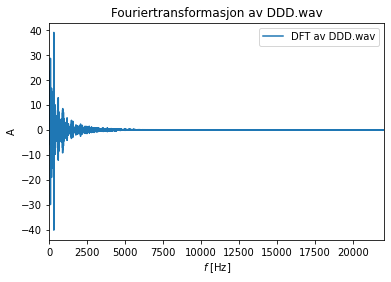

In [15]:
## Plotter frekvensspekteret til DDD
plt.xlim(0, fs_ddd/2) # Største mulige frekvens må være halvparten av samplingsfrekvensen (Nyquist)
plt.title(f"Fouriertransformasjon av {lydfil_ddd}")
plt.xlabel("$f$ [Hz]")
plt.ylabel("A")
plt.plot(freq_ddd, X_k_ddd, label=f"DFT av {lydfil_ddd}")
plt.legend()

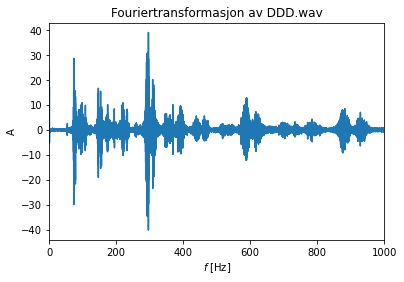

In [16]:
## Zoomer inn på plottet av frekvensspekteret til DDD til relevante verdier
plt.xlim(0, 1000)
plt.title(f"Fouriertransformasjon av {lydfil_ddd}")
plt.xlabel("$f$ [Hz]")
plt.ylabel("A")
plt.plot(freq_ddd, X_k_ddd, label=f"DFT av {lydfil_ddd}")

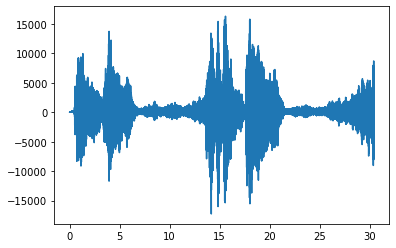

In [17]:
## Plotter lydsignalet fra utdraget på 30s
plt.plot(t_lu, x_n_lu)

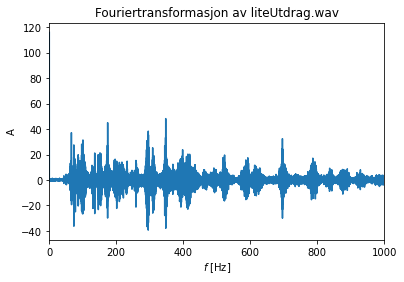

In [18]:
## Plotter frekvensspekteret til utdraget
plt.xlim(0, 1000)
plt.title(f"Fouriertransformasjon av {lydfil_lu}")
plt.xlabel("$f$ [Hz]")
plt.ylabel("A")
plt.plot(freq_lu, X_k_lu, label=f"DFT av {lydfil_lu}")

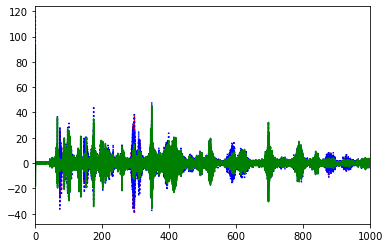

In [19]:
X_k_ny = X_k_lu - X_k_ddd # Fjerner frekvensene til DDD fra utdraget

## Plotter frekvensspekteret til DDD, utdraget, og differansen
plt.xlim(0,1000)
plt.plot(freq_ddd, X_k_ddd, "r:")
plt.plot(freq_lu, X_k_lu, "b:")
plt.plot(freq_lu, X_k_ny, "g")

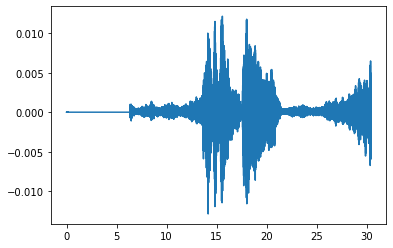

In [20]:
x_n_ny = np.fft.ifft(X_k_ny) # Invers Fouriertransformasjon, for å få tilbake lydsignalet uten DDD

## Plotter det nye lydsignalet
plt.plot(t_lu, x_n_ny)

In [21]:
wavfile.write("bby.wav", fs_lu, np.real(x_n_ny)) # Skriver lydsignalet ut til ny lydfil

In [22]:
K = 4 #setter K verdien
N_ddd = int(len(x_n_ddd)) # definerer hvor mange 

wavelet(x_n_ddd[::100],K,fs_ddd,freq_ddd,N_ddd,t_ddd) # kjører plottefunksjonen